In [1]:
import networkx as nx
import osmnx as ox
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import xml.etree.ElementTree as ET
import numpy as np
import os
from tqdm import tqdm
from heapq import heappush, heappop
from collections import defaultdict
import time
import sys
import shutil
import pickle

ox.settings.useful_tags_way = ['name','higway' ]
#ox.settings.useful_tags_node = ['name']
np.set_printoptions(suppress=True)
ox.utils.config(imgs_folder='/home/dankiy/python_projects/graph/output/', useful_tags_node=['name'])
#ox.utils.config(imgs_folder='/home/iref/PycharmProjects/Graphs/output/', useful_tags_node=['name'])

path = '../output/'

np.random.seed(0)

In [2]:
def build_graph_from_osm_file(osm_file_path = '../data/all.osm', retain_all=True, simplify=False):
    graph = ox.graph_from_file(osm_file_path, retain_all=retain_all, simplify=simplify)
    largest_component = list(max(nx.strongly_connected_components(graph), key=len))
    
    return graph, largest_component

In [3]:
def get_object_ids(object_type, osm_file_path='../data/all.osm', object_category='amenity'):
    root = ET.parse(osm_file_path).getroot()
    nodes = root.findall('./way')

    res_list = []

    for node in nodes:
        refs_list = []
        tags_list = []
        for child in node:
            if 'ref' in list(child.attrib.keys()):
                refs_list.append(int(child.attrib['ref']))
            else:
                tags_list.append({'key':child.attrib['k'], 'value':child.attrib['v']})
        for el in tags_list:
            if el['key'] ==object_category and el['value']==object_type:
                res_list.append(np.random.choice(refs_list))
                
    return list(set(res_list))

In [4]:
def get_object_ids_wrapper():
    health_list = get_object_ids(object_category='healthcare', object_type='hospital')
    ed_list = get_object_ids(object_type='school')
    shops_list = get_object_ids(object_type='mall')
    obj_list = health_list + ed_list + shops_list
    
    apts_list = get_object_ids(object_category='building', object_type='apartments')
    detached_list = get_object_ids(object_category='building', object_type='detached')
    nodes_list = apts_list + detached_list
    
    return set(obj_list), set(nodes_list)

In [5]:
def get_objects_sample(objects_list, N, largest_component=None):
    objects_list = np.array(objects_list)
    
    if largest_component:
        objects_list_filtered = objects_list[np.isin(objects_list, largest_component)]
    else:
        objects_list_filtered = objects_list
    objects_sample = np.random.choice(objects_list_filtered, N, replace=False)
    
    return list(objects_sample)

In [6]:
def get_higway_points(osm_file_path='../data/all.osm'):
        root = ET.parse(osm_file_path).getroot()
        nodes = root.findall('./way')
        res_list = []
        for node in nodes:
            refs_list = []
            tags_list = []
            for child in node:
                if 'ref' in list(child.attrib.keys()):
                    refs_list.append(int(child.attrib['ref']))
                else:
                    tags_list.append({'key':child.attrib['k'], 'value':child.attrib['v']})
            for el in tags_list:
                if el['key'] =='highway':
                    res_list.append(refs_list)
        res_list = [point for sublist in res_list for point in sublist]
        return(res_list)

In [7]:
def corrected_objects(graph, objects_list, points_list):
    points_list = np.array(points_list)
    
    simp_dict = dict(graph.nodes(data=True))
    obj_coords = np.array([list(simp_dict[key].values())[:2] for key in objects_list])
    point_coords = np.array([list(simp_dict[key].values())[:2] for key in points_list])

    nearest_ids = [np.argmin(np.linalg.norm(point_coords - oc, axis=1)) for oc in obj_coords]
    corrected_objects = points_list[nearest_ids]
    
    return list(set(corrected_objects))

In [8]:
def get_resulting_graph(graph, objects_list, nodes_list, visualize, strong_components=False, isolates=False):
    graph_simp = ox.simplify.simplify_graph(graph)
    print(len(nodes_list))
    
    graph_dict = dict(graph.nodes(data=True))
    df_obj = pd.DataFrame({node:graph_dict[node] for node in objects_list if node in graph_dict}).T
    print('Nodes number be4 adding:', len(graph_simp.nodes))
    print('df_obj:', len(df_obj))
    df_nodes = pd.DataFrame({node:graph_dict[node] for node in nodes_list if node in graph_dict}).T
    print('df_nodes:', len(df_nodes))
    for simp_path in ox.simplify.get_paths_to_simplify(graph):
        for osmid in simp_path:
            argwhere = np.argwhere(df_obj['osmid'].to_numpy() == osmid)
            if argwhere.size > 0 and osmid not in list(graph_simp.nodes):
                i = argwhere[0][0]
                obj_node = df_obj.iloc[i].to_dict()
                graph_simp.add_node(osmid, **obj_node)
                graph_simp.add_edge(simp_path[0], osmid)
                graph_simp.add_edge(osmid, simp_path[-1])
                   
                
    print('Nodes number after objects adding:',len(graph_simp.nodes))
    print('Objects inters:', len(set(objects_list).intersection(set(graph_simp.nodes()))))
                
    for simp_path in ox.simplify.get_paths_to_simplify(graph):
        for osmid in simp_path:
            argwhere = np.argwhere(df_nodes['osmid'].to_numpy() == osmid)
            if argwhere.size > 0 and osmid not in list(graph_simp.nodes):
                i = argwhere[0][0]
                obj_node = df_nodes.iloc[i].to_dict()
                graph_simp.add_node(osmid, **obj_node)
                graph_simp.add_edge(simp_path[0], osmid)
                graph_simp.add_edge(osmid, simp_path[-1])
        
    print('Nodes number after nodes adding:',len(graph_simp.nodes))
    print('Nodes inters:', len(set(nodes_list).intersection(set(graph_simp.nodes()))))
    
    if strong_components:
        for component in list(nx.strongly_connected_components(graph_simp)):
            if len(component)<100:
                for node in component:
                    to_remove = []
                    if node not in (nodes_list + objects_list):
                        to_remove.append(node)
                    else:
                        break
                    graph_simp.remove_nodes_from(to_remove)

    print(len(graph_simp.nodes))
    
    if isolates:
        graph.remove_nodes_from(list(nx.isolates(graph)))
                
    if visualize:
        oc = ['r' if osmid in objects_list else 'g' if osmid in nodes_list
              else 'b' for osmid in graph_simp.nodes()]
        os = [200 if osmid in objects_list or osmid in nodes_list   
              else 10 for osmid in graph_simp.nodes()]
        fig, ax = ox.plot_graph(graph_simp, node_color = oc, node_size=os, fig_height=18)
        #plt.savefig(path+'Overall_nodes.png')
        
        
        pos = {}
        for key in list(graph_dict.keys()):
            pos[key] = (graph_dict[key]['x'], graph_dict[key]['y'])
        labels = {}
        for i in range(len(objects_list)):
            labels[objects_list[i]] = 'O' + str(i)
        for j in range(len(nodes_list)):
            labels[nodes_list[j]] = 'N' + str(j)
        plt.figure(figsize=(30,18))    
        nc = ['r' if nid in objects_list else 'g' for nid in objects_list + nodes_list]
        nx.draw_networkx(G, pos=pos, nodelist=objects_list + nodes_list, node_color=nc, with_labels=False, arrows=False, node_size=350, edge_color='gray')
        nx.draw_networkx_labels(G,pos=pos, labels=labels, font_size=10)
        plt.savefig(path+'Chosen_nodes_and_objects.png')
        

    return graph_simp

In [9]:
def init_weights(graph, objects_list):
    weight_factor = 1.5
    for obj_id in objects_list:
        graph.nodes[obj_id]['weight'] = weight_factor

Упаковка в csv

In [10]:
def packing(graph, output_path=path, adj_mat = False):
    if adj_mat:
        df_matrix = nx.to_pandas_adjacency(graph, dtype=np.uint8)
        df_matrix.to_csv(output_path+'Adj_matrix_bbike_map.csv', index=False)

    adj_list = list(nx.generate_adjlist(graph))
    df_list = pd.DataFrame(adj_list, columns = ['row'])
    df_list = pd.DataFrame(df_list.row.str.split(' ').tolist())
    df_list = df_list.rename(columns={0: 'Source'})
    df_list.to_csv(output_path+'Adj_list_bbike_map.csv', index=False)
    df_nodes = pd.DataFrame(dict(G.nodes(data=True))).T
    df_nodes.to_csv(output_path+'All.csv', index=False)
    to_dict_nodes = df_nodes.loc[df_nodes['osmid'].isin(c_nodes)] 
    to_dict_nodes.to_csv(output_path+'Nodes_bbike_map.csv', index=False)
    to_dict_objects = df_nodes.loc[df_nodes['osmid'].isin(c_obj)] 
    to_dict_objects.to_csv(output_path+'Objects_bbike_map.csv', index=False)
    adj_list = pd.read_csv(output_path+'Adj_list_bbike_map.csv')
    df_graph = df_nodes.merge(adj_list, left_on='osmid', right_on='Source')
    adj = df_graph.iloc[:,6:].to_numpy()
    adj = [node[~pd.isnull(node)] for node in adj]
    df_graph['adj'] = adj
    df_graph = df_graph[['osmid','x','y','name','adj']].set_index('osmid')
    df_graph.drop(columns=['name'])
    
    with open(output_path+'Rostov3_simp.pickle', 'wb') as f:
        pickle.dump(graph, f)
    
    return df_graph

In [11]:
def df_to_edges(graph: pd.DataFrame):
    graph_dict = graph.T.to_dict()
    edges = defaultdict(list)
    
    for src_id, row_dict in graph_dict.items():
        src_x = row_dict['x']
        src_y = row_dict['y']
        
        for dst_id in row_dict['adj']:
            dst_x = graph_dict[dst_id]['x']
            dst_y = graph_dict[dst_id]['y']
            cost = gaversin_distance(src_x, src_y, dst_x, dst_y)

            edges[src_id].append((cost, dst_id))
            
    return edges

In [12]:
def gaversin_distance(x1, y1, x2, y2):
    R = 6371
    x1 = x1 * np.pi/180
    x2 = x2 * np.pi/180
    y1 = y1 * np.pi/180
    y2 = y2 * np.pi/180
    sin1 = np.sin((y2-y1)/2)
    sin2 = np.sin((x2-x1)/2)
    dist = 2 * R * np.arcsin(np.sqrt(sin1**2 + (sin2**2)*np.cos(y1)*np.cos(y2)))
    
    return dist

In [13]:
def dijkstra(graph : pd.DataFrame, edges : dict, src : int, dst : set):
    mins = {vertex : {'cost' : np.inf, 'path' : ()} for vertex in graph.index}
    mins[src] = {'cost' : 0, 'path' : (src,src)}
    seen = set()
    dst_control = dst.copy()
    
    queue = [(0, src, ())]
    while queue and dst_control:
        (cost1, vertex1, path) = heappop(queue)
        
        if vertex1 not in seen:
            seen.add(vertex1)
            dst_control.discard(vertex1)
            path = path+tuple([vertex1])

            for cost2, vertex2 in edges.get(vertex1, ()):
                if vertex2 in seen: 
                    continue
                    
                prev = mins.get(vertex2, None)['cost']
                curr = cost1 + cost2
                
                if prev is None or curr < prev:
                    mins[vertex2] = {
                        'cost' : curr,
                        'path' : path+tuple([vertex2])
                    }
                    heappush(queue, (curr, vertex2, path))
    
    mins = {vertex : cost_path for vertex, cost_path in mins.items() if vertex in dst}
    return mins 

In [14]:
def get_path(graph, graph_df, graph_edges, node_num, objects_list, nodes_list, output_path = '../output/1a/'):
    
    res_df = pd.DataFrame(columns=['type', 'src', 'dst', 'cost', 'path'])
    
    
    res_dict_from = {}
    from_dict = dijkstra(graph_df, graph_edges, nodes_list[node_num], set(objects_list))
    min_cost = sys.maxsize
    oid_from = 0
    way_from = ()
    for k in list(from_dict.keys()):
        if from_dict[k]['cost'] < min_cost:
            min_cost = from_dict[k]['cost']
            oid_from = k
            way_from = from_dict[k]['path']
    res_dict_from['from_node'] = {objects_list.index(oid_from): min_cost}
    oid_from_num = objects_list.index(oid_from)
    
    
    row_from = {'type':'from', 'src':node_num, 'dst':oid_from_num, 
                'cost':res_dict_from['from_node'][objects_list.index(oid_from)], 'path':way_from}
    res_df = res_df.append(row_from, ignore_index=True)
    
    
    to_dict = {}
    for oid in objects_list:
        to_dict[oid] = dijkstra(graph_df, graph_edges, oid, set(c_nodes))[c_nodes[node_num]]
    min_cost = sys.maxsize
    oid_to = 0
    way_to = ()
    for k in list(to_dict.keys()):
        if to_dict[k]['cost'] < min_cost:
            min_cost = to_dict[k]['cost']
            oid_to = k
            way_to =  to_dict[k]['path']
            
    
    oid_to_num = objects_list.index(oid_to)        
    res_dict_from['to_node'] = {objects_list.index(oid_to): min_cost}
    
    row_to = {'type':'to', 'src':node_num, 'dst':oid_to_num, 
              'cost':res_dict_from['to_node'][objects_list.index(oid_to)], 'path':way_to}
    res_df = res_df.append(row_to, ignore_index=True)
 
    
    
    sum_dict = {}
    for k in list(from_dict.keys()):
        sum_dict[k] = to_dict[k]['cost'] + from_dict[k]['cost']
    min_cost = sys.maxsize
    oid_sum = 0
    for k in list(sum_dict.keys()):
        if sum_dict[k] < min_cost:
            min_cost = sum_dict[k]
            oid_sum = k      
    res_dict_from['sum'] = {objects_list.index(oid_sum): min_cost}
    
    oid_sum_num = objects_list.index(oid_sum)
    
    row_sum = {'type':'sum_from', 'src':node_num, 'dst':oid_sum_num, 
               'cost':res_dict_from['sum'][objects_list.index(oid_sum)], 'path':from_dict[oid_sum]['path']}                                                                                                    
    res_df = res_df.append(row_sum, ignore_index=True)
    
    row_sum = {'type':'sum_to', 'src':node_num, 'dst':oid_sum_num, 
               'cost':res_dict_from['sum'][objects_list.index(oid_sum)], 'path':to_dict[oid_sum]['path']}
    
    
    
    res_df = res_df.append(row_sum, ignore_index=True)
    
    
    
    
    from_node_subg = graph.subgraph(from_dict[oid_from]['path'])
    from_edges = list(from_node_subg.edges)
    
    to_node_subg = graph.subgraph(to_dict[oid_to]['path'])
    to_edges = list(to_node_subg.edges)
    
    sum_subg_from = graph.subgraph(from_dict[oid_sum]['path'])
    sum_edges_from = list(sum_subg_from.edges)
    
    sum_subg_to = graph.subgraph(to_dict[oid_sum]['path'])
    sum_edges_to = list(sum_subg_to.edges)
    
 
    
    nc = ['r' if osmid in [oid_from, oid_to, oid_sum] else 'g' if osmid==nodes_list[node_num] else 'gray' for osmid in graph.nodes()]
    ns = [400 if osmid in [oid_from, oid_to, oid_sum, nodes_list[node_num]] else 10 for osmid in graph.nodes()]
    ec = ['orange' if edge in from_edges else 'yellow' if edge in to_edges else 'purple' if edge in sum_edges_to + sum_edges_from  else 'gray' for
         edge in list(graph.edges)]
    ew = [5 if edge in from_edges+to_edges else 1 for  edge in list(graph.edges)]
    
    
    if os.path.exists(output_path):
        shutil.rmtree(output_path)
    os.mkdir(output_path)
    
    res_df.to_csv('../output/1a/1a.csv', index=False)
    fig, ax = ox.plot_graph(graph, node_color=nc, node_size=ns, edge_color=ec, edge_linewidth=ew, 
                            fig_height=18,
                            save=True, filename='1a/1a')
    
    return node_num, res_dict_from['from_node'],  res_dict_from['to_node'], res_dict_from['sum']

In [15]:
def get_filtered_paths(graph, graph_df, graph_edges, node_num, objects_list, nodes_list, x_limit, output_path = '../output/1b/'):
    
    res_df = pd.DataFrame(columns=['type', 'range', 'src', 'dst', 'cost', 'path'])
    
    from_dict = dijkstra(graph_df, graph_edges, nodes_list[node_num], set(objects_list))
    oids_from = []
    ways_from = []
    oids_costs_from = {}
    
    for k in list(from_dict.keys()):
        if from_dict[k]['cost'] < x_limit:
            oids_from.append(k)
            curr_cost = from_dict[k]['cost']
            curr_num = objects_list.index(k)
            oids_costs_from[curr_num] = curr_cost
            ways_from.append(from_dict[k]['path'])
    
    edges_from = []
    for way in ways_from:
        temp_subg = graph.subgraph(way)
        temp_edges = list(temp_subg.edges)
        edges_from.append(temp_edges)
        
        #print(from_dict)
    
    for k, v in oids_costs_from.items():
        row_from = {'type':'from', 'range':x_limit, 'src':node_num, 'dst':k, 'cost':v, 'path':from_dict[objects_list[k]]['path']}
        res_df = res_df.append(row_from, ignore_index=True)
    
    

    to_dict = {}
    for oid in objects_list:
        to_dict[oid] = dijkstra(graph_df, graph_edges, oid, set(c_nodes))[c_nodes[node_num]]
    
    
    oids_to = []
    ways_to = []
    oids_costs_to = {}
    for k in list(to_dict.keys()):
        if to_dict[k]['cost'] < x_limit:
            oids_to.append(k)
            curr_cost = to_dict[k]['cost']
            curr_num = objects_list.index(k)
            oids_costs_to[curr_num] = curr_cost
            ways_to.append(from_dict[k]['path'])
    
    edges_to = []
    for way in ways_to:
        temp_subg = graph.subgraph(way)
        temp_edges = list(temp_subg.edges)
        edges_to.append(temp_edges)
        
        
        
    for k, v in oids_costs_to.items():
        row_to = {'type':'to', 'range':x_limit, 'src':node_num, 'dst':k, 'cost':v, 'path':to_dict[objects_list[k]]['path']}
        res_df = res_df.append(row_to, ignore_index=True)
        
        
        
    oids_sum = []
    oids_costs_sum = {}
    
    sum_dict = {}
    for k in list(from_dict.keys()):
        sum_dict[k] = to_dict[k]['cost'] + from_dict[k]['cost']
        
    for k in list(sum_dict.keys()):
        if sum_dict[k] < x_limit:
            oids_sum.append(k)
            curr_cost = sum_dict[k]
            curr_num = objects_list.index(k)
            oids_costs_sum[curr_num] = curr_cost
            
            
    for k, v in oids_costs_sum.items():
        row_sum = {'type':'sum', 'range':x_limit, 'src':node_num, 'dst':k, 'cost':v, 'path':{'from':from_dict[objects_list[k]]['path'], 
                                                                                             'to':to_dict[objects_list[k]]['path']}}
        res_df = res_df.append(row_sum, ignore_index=True)
        
    
        
    edges_from = [item for sublist in edges_from for item in sublist]
    edges_to = [item for sublist in edges_to for item in sublist]
    

    
    
    nc = ['r' if osmid in oids_from + oids_to else 'g' if osmid==nodes_list[node_num] else 'gray' for osmid in graph.nodes()]
    ns = [400 if osmid in oids_from + oids_to or osmid==nodes_list[node_num]
          else 10 for osmid in graph.nodes()]
    
    ec = ['orange' if edge in edges_from else 'yellow' if edge in edges_to else 'gray' for edge in list(graph.edges)]
    ew = [5 if edge in edges_from + edges_to else 1 for 
         edge in list(graph.edges)]
    
    
    if os.path.exists(output_path):
        shutil.rmtree(output_path)
    os.mkdir(output_path)
    
    res_df.to_csv('../output/1b/1b.csv', index=False)
    
    fig, ax = ox.plot_graph(graph, node_color=nc, node_size=ns, edge_color=ec, edge_linewidth=ew, 
                            fig_height=18,
                            save=True, filename='1b/1b')
    
    return node_num, oids_costs_from, oids_costs_to, oids_costs_sum

In [16]:
def get_minmax_obj_path(graph, graph_df, graph_edges, objects_list, nodes_list, output_path='../output/2'):
    res_dict = {}
    
    res_df = pd.DataFrame(columns=['src', 'dst', 'cost', 'path'])
    
    
    from_dict = {}
    for oid in objects_list:
        from_dict[oid] = dijkstra(graph_df, graph_edges, oid, set(nodes_list))
        
    temp_dict = {}

    for k, v in from_dict.items():

        max_cost = 0
        nnum = 0
        oid = 0
        for nid in nodes_list:
            try:
                cost = v[nid]['cost']
            except:
                print('.')
                print('k: ', k)
                print('v: ', v[nid])
                print('.')
            if cost > max_cost and cost != np.inf:
                max_cost = cost
                oid = k
            if oid !=0:
                temp_dict[objects_list.index(oid)] = (nodes_list.index(nid), max_cost, nid)

        
    onum_from = 0
    nnum_from = 0
    minmax_from = sys.maxsize
    for k,v in temp_dict.items():
        if v[1] < minmax_from:
            onum_from = k
            minmax_from = v[1]
            nnum_from = v[0]
            #nid_from = v[2]
    
        
    res_dict['from'] = (onum_from, nnum_from, minmax_from)
    
    
    way_from = from_dict[objects_list[onum_from]][nodes_list[nnum_from]]['path']
    cost_from = from_dict[objects_list[onum_from]][nodes_list[nnum_from]]['cost']
    subg_from = graph.subgraph(way_from)
    edges_from = subg_from.edges
    
    row_from = {'src':onum_from, 'dst':nnum_from, 'cost':cost_from, 'path':way_from}
    res_df = res_df.append(row_from, ignore_index=True)
    
       
    to_dict = {}
    for nid in nodes_list:
        to_dict[nid] = dijkstra(graph_df, graph_edges, nid, set(objects_list))
    
    temp_dict = {}
    for k,v in to_dict.items():
        max_cost = 0
        nnum = 0
        nid = 0
        for oid in objects_list:
            cost = v[oid]['cost']
            if cost > max_cost and cost != np.inf:
                max_cost = cost
                nid = k
            if nid != 0:
                temp_dict[objects_list.index(oid)] = (nodes_list.index(nid), max_cost, nid)
    
    onum_to = 0
    nnum_to = 0
    minmax_to = sys.maxsize
    for k,v in temp_dict.items():
        if v[1] < minmax_to:
            onum_to = k
            minmax_to = v[1]
            nnum_to = v[0]
            nid_to = v[2]
    
    res_dict['to'] = (onum_to, nnum_to, minmax_to)
    
    way_to = to_dict[nodes_list[nnum_to]][objects_list[onum_to]]['path']
    cost_to = to_dict[nodes_list[nnum_to]][objects_list[onum_to]]['cost']
    subg_to = graph.subgraph(way_to)
    edges_to = subg_to.edges
    
    row_to = {'src':onum_to, 'dst':nnum_to, 'cost':cost_to, 'path':way_to}
    res_df = res_df.append(row_to, ignore_index=True)
    
    
    temp_dict = {}
    for oid in c_obj:
        max_cost = 0
        nnum = 0
        nid_g = 0
        oid_g = 0
        for nid in c_nodes:
            cost_to = to_dict[nid][oid]['cost']
            cost_from = from_dict[oid][nid]['cost']
            if cost_from != np.inf and cost_to !=np.inf:
                cost_sum = cost_from + cost_to 
            if cost_sum > max_cost:
                max_cost = cost_sum
                nid_g = nid
                oid_g = oid
            if nid_g !=0 and oid_g!=0:
                temp_dict[c_obj.index(oid_g)] = (c_nodes.index(nid_g), max_cost, nid_g)
                
                
    onum_sum = 0
    nnum_sum = 0
    minmax_sum = sys.maxsize
    for k,v in temp_dict.items():
        if v[1] < minmax_sum:
            onum_sum = k
            minmax_sum = v[1]
            nnum_sum = v[0]
            nid_sum = v[2]
    res_dict['sum'] = (onum_sum, nnum_sum, minmax_sum)
       
    way_sum_to = to_dict[nodes_list[nnum_sum]][objects_list[onum_sum]]['path']
    cost_sum_to = to_dict[nodes_list[nnum_sum]][objects_list[onum_sum]]['cost']
    way_sum_from = from_dict[objects_list[onum_sum]][nodes_list[nnum_sum]]['path']
    cost_sum_from = from_dict[objects_list[onum_sum]][nodes_list[nnum_sum]]['cost']
    
    subg_sum_to = graph.subgraph(way_sum_to)
    subg_sum_from = graph.subgraph(way_sum_from)
    
    edges_sum_to = subg_sum_to.edges
    edges_sum_from = subg_sum_from.edges
    
    row_sum_from = {'src':onum_sum, 'dst':nnum_sum, 'cost':cost_sum_from, 'path':way_sum_from}
    res_df = res_df.append(row_sum_from, ignore_index=True)
    
    row_sum_to = {'src':nnum_sum, 'dst':onum_sum, 'cost':cost_sum_to, 'path':way_sum_to}
    res_df = res_df.append(row_sum_to, ignore_index=True)
    
    
    
    
    res_objects = [objects_list[onum_from], objects_list[onum_to], objects_list[onum_sum]]
    res_nodes = [nodes_list[nnum_from], nodes_list[nnum_to], nodes_list[nnum_sum]] 
    res_edges = list(edges_from) + list(edges_to) + list(edges_sum_to) + list(edges_sum_from)
    sum_edges = list(edges_sum_to) + list(edges_sum_from)
    
    nc = ['r' if osmid in res_objects   else 'g' if osmid in res_nodes else 'gray' for osmid in graph.nodes()]
    ns = [400 if osmid in res_objects or osmid in res_nodes else 10 for osmid in graph.nodes()]
    ec = ['orange' if edge in edges_from else 'yellow' if edge in edges_to else 'purple' if edge in sum_edges 
          else 'gray' for edge in list(graph.edges)]
    ew = [5 if edge in res_edges  else 1 for 
         edge in list(graph.edges)]   
    
    if os.path.exists(output_path):
        shutil.rmtree(output_path)
    os.mkdir(output_path)
    res_df.to_csv('../output/2/2.csv')
    
    fig, ax = ox.plot_graph(graph, node_color=nc, node_size=ns, edge_color=ec, edge_linewidth=ew, 
                            fig_height=18,
                            save=True, filename='2/2')
        
    
    return res_dict

In [17]:
def get_shortest_paths_sum(graph, graph_df, graph_edges, objects_list, nodes_list, output_path='../output/3'):
    distances = {}
    for oid in objects_list:
        distances[oid] = dijkstra(graph_df, graph_edges, oid, set(nodes_list))
    
    min_sum = sys.maxsize
    res_obj = 0
    for k,v in distances.items():
        obj_sum = 0
        for nid in nodes_list:
            if v[nid]['cost'] !=np.inf:
                obj_sum += v[nid]['cost'] 
        if obj_sum < min_sum:
            min_sum = obj_sum
            res_obj = k
            
    res_obj_num = objects_list.index(res_obj)
            
    paths = []

    
    for nid in nodes_list:
        if distances[res_obj][nid]['cost'] != np.inf:
            paths.append(distances[res_obj][nid]['path'])
            
    
    
    edges = []
    for path in paths:
        path_subg = graph.subgraph(path)
        path_edges = path_subg.edges
        edges.append(path_edges)
    
    edges = [item for sublist in edges for item in sublist]
    
    
    res_dict = {}
    for k, v in distances[res_obj].items():
        res_dict[nodes_list.index(k)] = v
    
    
    res_df = pd.DataFrame(res_dict).T
    

    
    nc = ['r' if osmid==res_obj   else 'g' if osmid in nodes_list else 'gray' for osmid in graph.nodes()]
    ns = [400 if osmid==res_obj or osmid in nodes_list else 10 for osmid in graph.nodes()]
    ec = ['orange' if edge in edges else 'gray' for edge in list(graph.edges)]
    ew = [5 if edge in edges  else 1 for edge in list(graph.edges)]   
    
        
    if os.path.exists(output_path):
        shutil.rmtree(output_path)
    os.mkdir(output_path)
    res_df.to_csv('../output/3/3_paths_from_object_{}.csv'.format(res_obj_num))
    
    fig, ax = ox.plot_graph(graph, node_color=nc, node_size=ns, edge_color=ec, edge_linewidth=ew, 
                            fig_height=18,
                            save=True, filename='3/3')
        
    return res_obj_num, min_sum

In [18]:
def get_lightest_tree(graph, graph_df, graph_edges, objects_list, nodes_list, output_path='../output/4/'):
    distances = {}
    for oid in objects_list:
        distances[oid] = dijkstra(graph_df, graph_edges, oid, set(nodes_list))
    
    res = {}
 
    for k, v in distances.items():
        tree_edges = []
        dist = 0
        for nid in nodes_list:
            curr_path = v[nid]['path']
            for i in range(1, len(curr_path)):
                root = curr_path[i-1]
                dst = curr_path[i]
                edge = (root, dst) 
                if edge not in tree_edges:
                    tree_edges.append(edge)
                    x1 = graph_df.loc[root, 'x']
                    y1 = graph_df.loc[root, 'y']
                    x2 = graph_df.loc[dst, 'x']
                    y2 = graph_df.loc[dst, 'y']
                    dist += gaversin_distance(x1, y1, x2, y2)
        
        res[k] = dist
        
        
        res_obj = 0
        min_weight = sys.maxsize
        for k,v in res.items():
            if v < min_weight:
                res_obj = k
                min_weight = v
                
    res_obj_num = objects_list.index(res_obj)
    
    paths = []

    
    for nid in nodes_list:
        if distances[res_obj][nid]['cost'] != np.inf:
            paths.append(distances[res_obj][nid]['path'])
    
    edges = []
    for path in paths:
        path_subg = graph.subgraph(path)
        path_edges = path_subg.edges
        edges.append(path_edges)
        
    
    res_dict = {}
    for k, v in distances[res_obj].items():
        res_dict[nodes_list.index(k)] = v
    
    
    res_df = pd.DataFrame(res_dict).T
       
    
    edges = [item for sublist in edges for item in sublist]
        
    nc = ['r' if osmid==res_obj   else 'g' if osmid in nodes_list else 'gray' for osmid in graph.nodes()]
    ns = [400 if osmid==res_obj or osmid in nodes_list else 10 for osmid in graph.nodes()]
    ec = ['orange' if edge in edges else 'gray' for edge in list(graph.edges)]
    ew = [5 if edge in edges  else 1 for edge in list(graph.edges)]   
    
    if os.path.exists(output_path):
        shutil.rmtree(output_path)
    os.mkdir(output_path)
    res_df.to_csv(output_path + '4_paths_from_object_{}.csv'.format(res_obj_num)) 
    
    fig, ax = ox.plot_graph(graph, node_color=nc, node_size=ns, edge_color=ec, edge_linewidth=ew, 
                            fig_height=18,
                            save=True, filename='4/4')
    
    
    
    
    return res_obj_num, min_weight

In [19]:
G, LC = build_graph_from_osm_file()

obj, nodes = get_object_ids_wrapper()
road_points = get_higway_points()
c_obj = corrected_objects(G, obj, road_points)
c_nodes = corrected_objects(G, nodes, road_points)

init_weights(G, c_obj)

c_obj = get_objects_sample(c_obj, N=10, largest_component=LC)
c_nodes = get_objects_sample(c_nodes, N=100, largest_component=LC)

100
Nodes number be4 adding: 58204
df_obj: 10
df_nodes: 100
Nodes number after objects adding: 58211
Objects inters: 10
Nodes number after nodes adding: 58279
Nodes inters: 100
9605


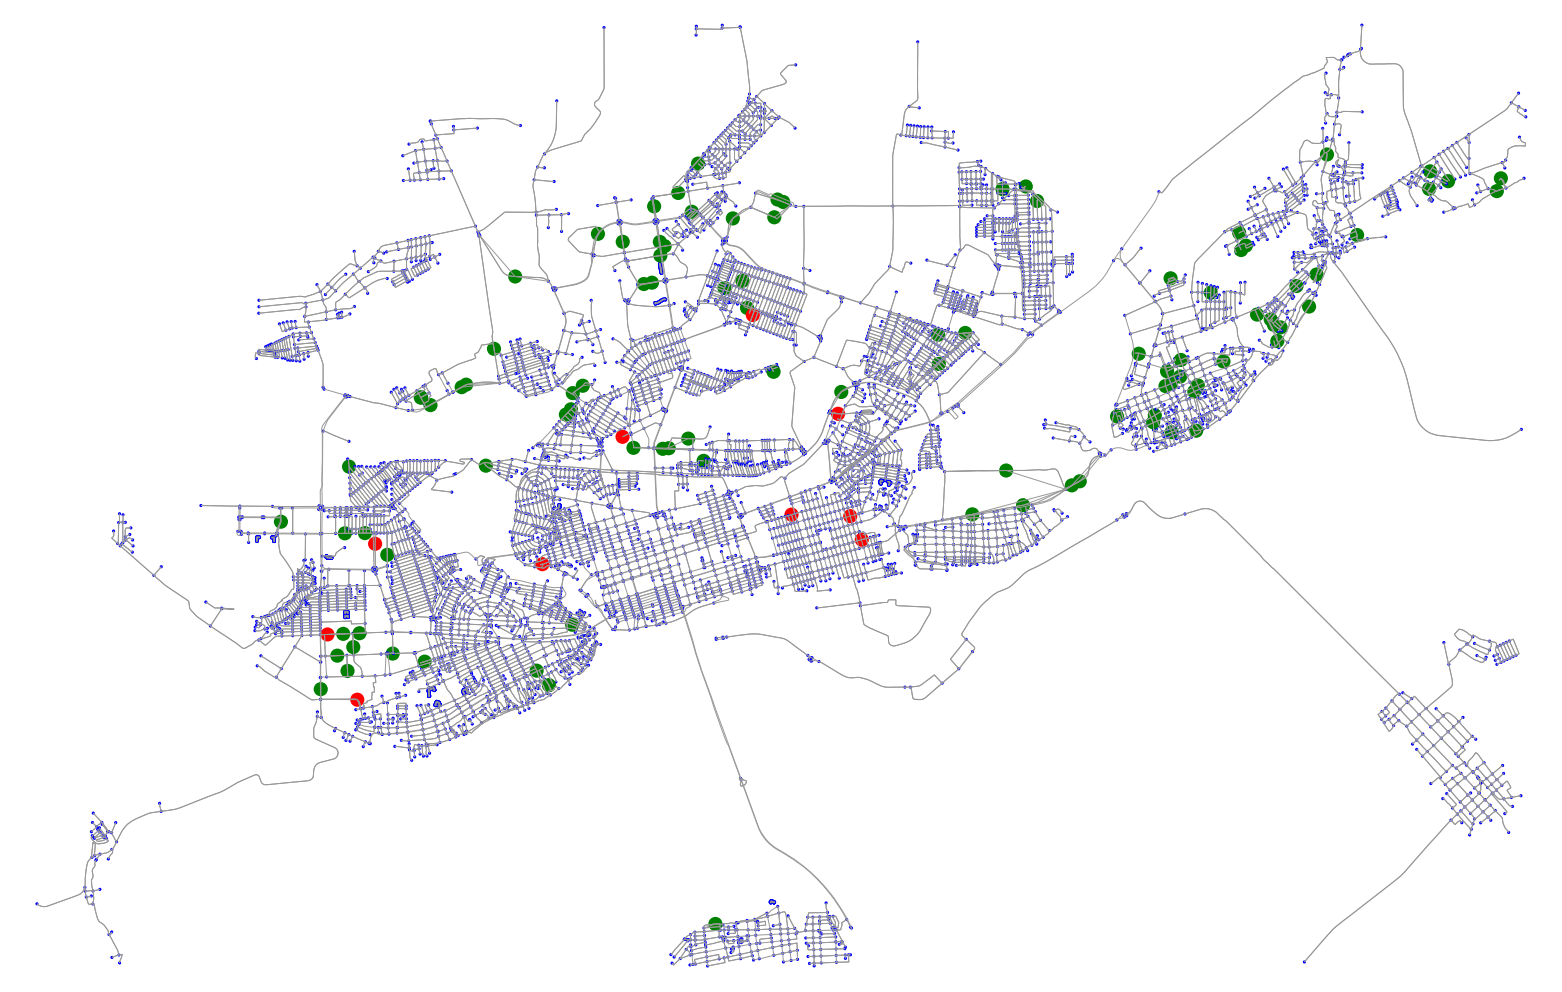

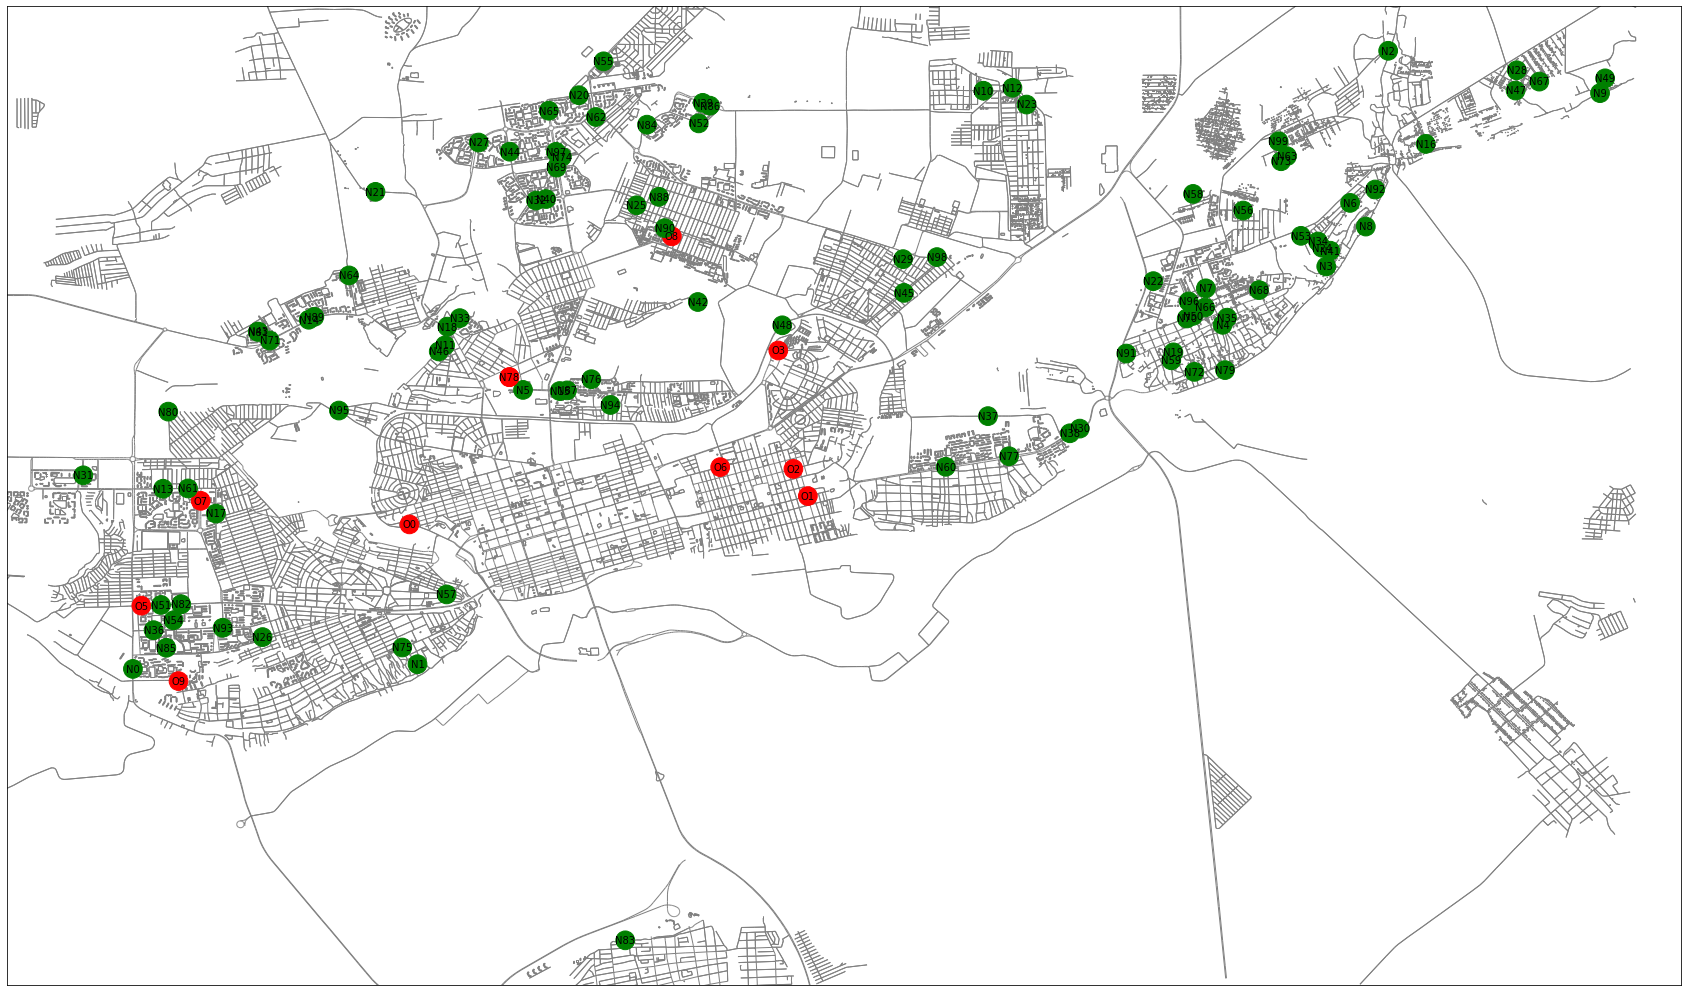

In [20]:
G = get_resulting_graph(G, c_obj, c_nodes, True, strong_components=True)

In [21]:
graph_df = packing(G)
graph_edges = df_to_edges(graph_df)

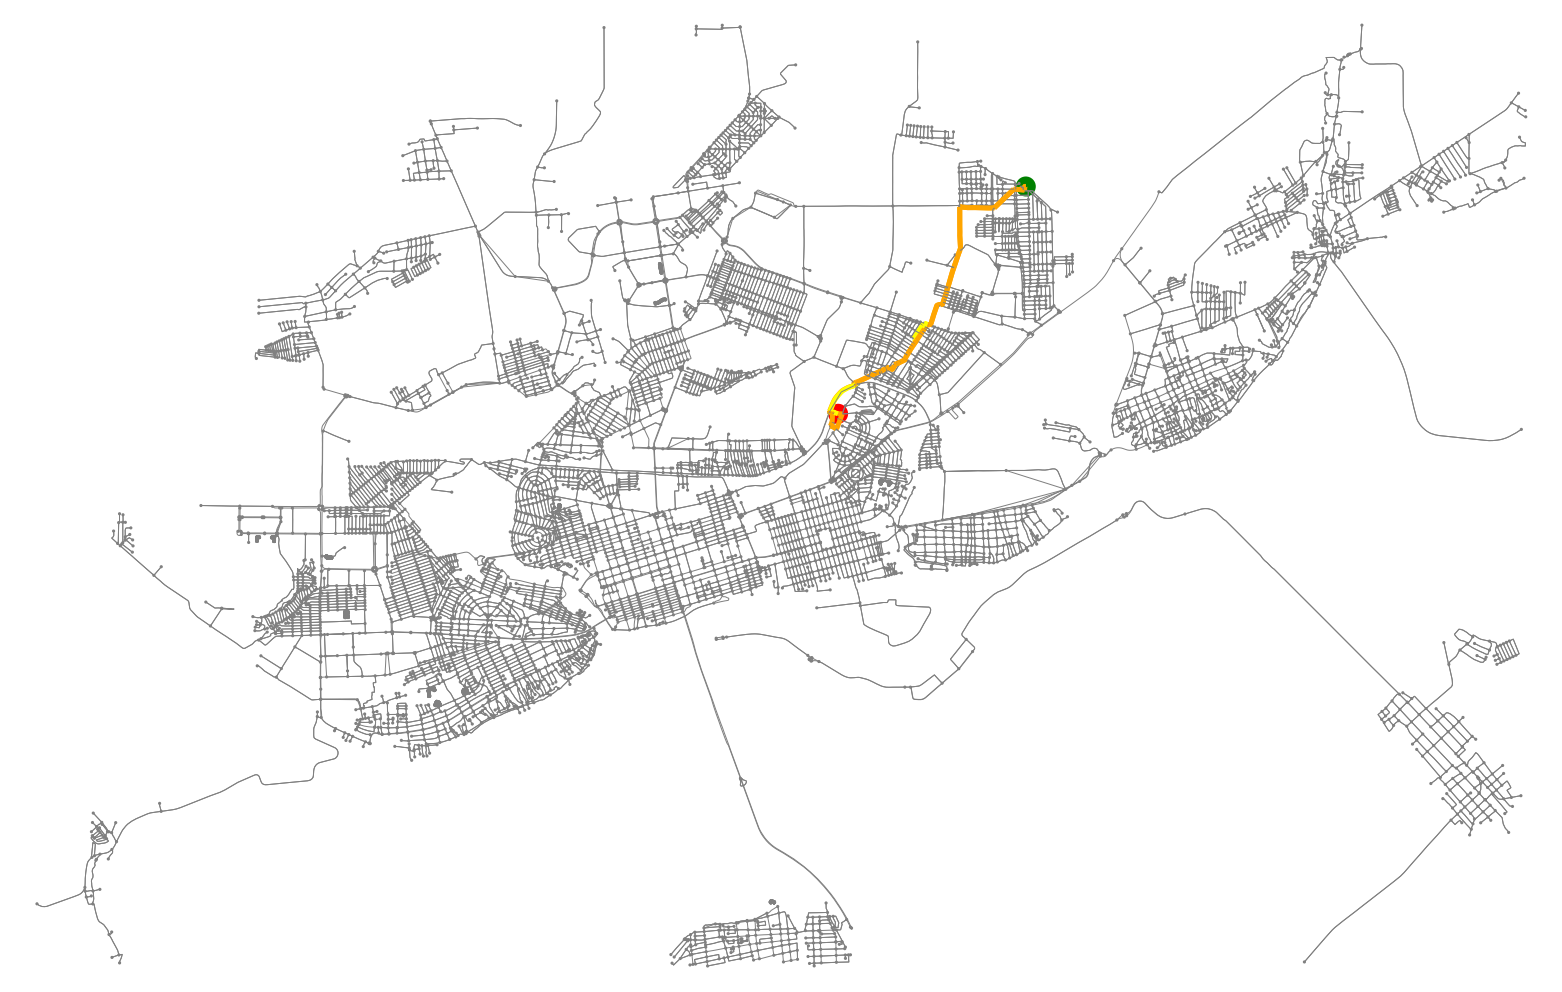

Номер узла(дома):
12
################################################################
Ближайший объект, расположенный по пути от узла(дома):
{3: 8.551838080029432}
################################################################
Ближайший объект, расположенный по пути к узлу(дому):
{3: 7.876451514360403}
################################################################
Ближайший объект, расположенный по пути "туда и обратно":
{3: 16.428289594389835}


In [22]:
n, a, b, c = get_path(G, graph_df, graph_edges, 12, c_obj, c_nodes)
print('Номер узла(дома):')
print(n)
print('#'*64)
print('Ближайший объект, расположенный по пути от узла(дома):')
print(a)
print('#'*64)
print('Ближайший объект, расположенный по пути к узлу(дому):')
print(b)
print('#'*64)
print('Ближайший объект, расположенный по пути "туда и обратно":')
print(c)

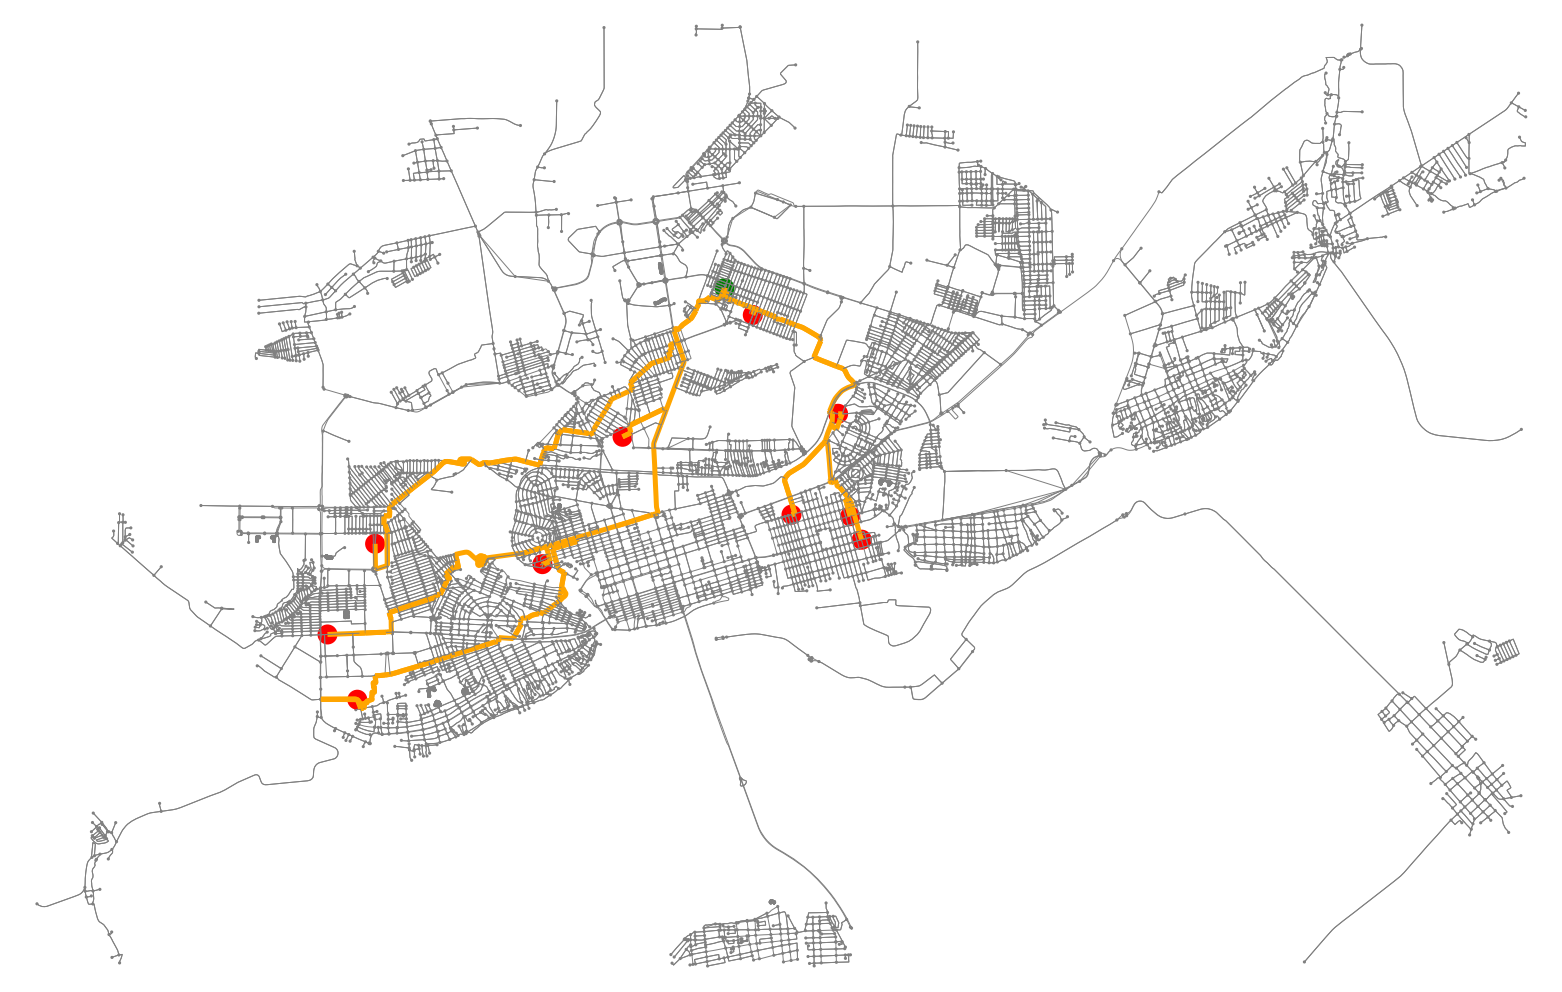

Номер узла(дома):
25
################################################################
Объекты, расположенные менее, чем в Х км по пути от узла(дома):
{6: 7.917036351691206, 2: 7.823019453657965, 4: 4.863861755581757, 8: 1.1433072482299989, 7: 12.923331567548539, 3: 6.0217794118232, 0: 9.087221795492773, 9: 17.218064764016926, 1: 8.347048796193846, 5: 14.878974121817324}
################################################################
Объекты, расположенные менее, чем в Х км по пути к узлу(дому):
{0: 9.264213079808641, 1: 9.623851545664266, 2: 8.743418643484555, 3: 5.3540712416940694, 4: 4.925291029263926, 5: 15.196064916152041, 6: 8.347829164964228, 7: 11.877449821596944, 8: 1.535686201407186, 9: 16.29562413099681}
################################################################
Объекты, расположенные менее, чем в Х км по пути "туда и обратно":
{6: 16.264865516655433, 2: 16.56643809714252, 4: 9.789152784845683, 8: 2.6789934496371846, 7: 24.800781389145484, 3: 11.375850653517269, 0: 18.

In [23]:
n,a,b,c = get_filtered_paths(G, graph_df, graph_edges, 25, c_obj, c_nodes, 25)
print('Номер узла(дома):')
print(n)
print('#'*64)
print('Объекты, расположенные менее, чем в Х км по пути от узла(дома):')
print(a)
print('#'*64)
print('Объекты, расположенные менее, чем в Х км по пути к узлу(дому):')
print(b)
print('#'*64)
print('Объекты, расположенные менее, чем в Х км по пути "туда и обратно":')
print(c)

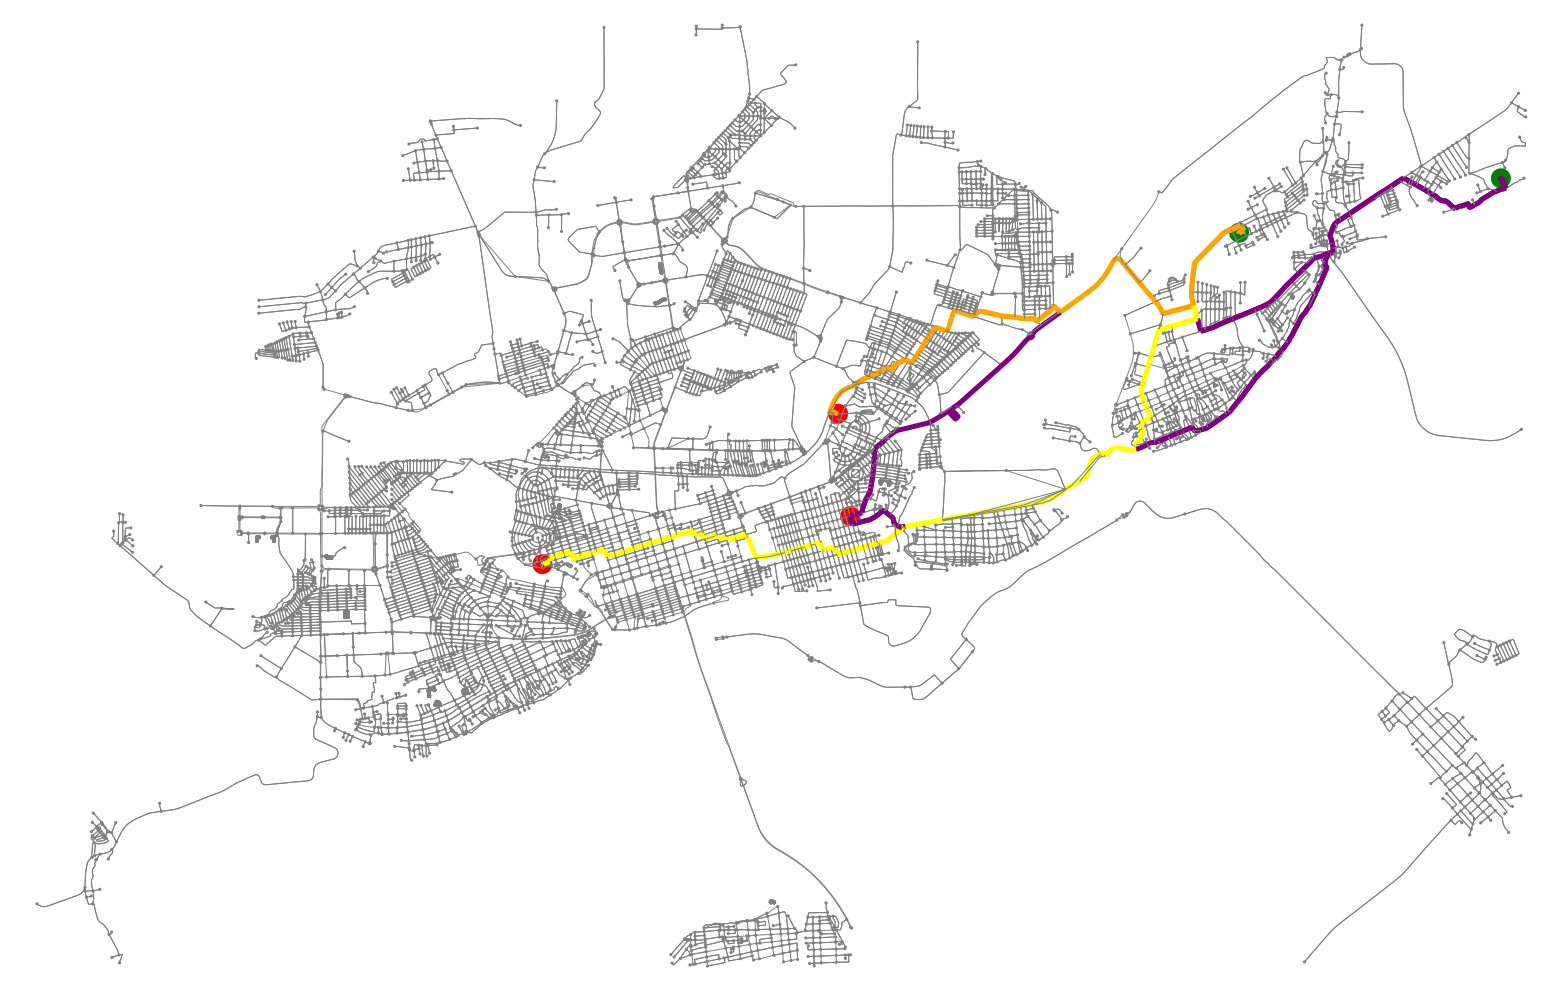

12.996694326400757
Путь "туда": объект, самый дальний дом, расстояние
(3, 99, 20.394472539399107)
################################################################
Путь "обратно": объект, самый дальний дом, расстояние
(0, 99, 22.08858435889272)
################################################################
Путь "туда и обратно": объект, самый дальний дом, расстояние
(2, 49, 40.04731407145066)


In [24]:
start = time.time()
test = get_minmax_obj_path(G, graph_df, graph_edges, c_obj, c_nodes)
end = time.time()
print(end - start)
print('Путь "туда": объект, самый дальний дом, расстояние')
print(test['from'])
print('#'*64)
print('Путь "обратно": объект, самый дальний дом, расстояние')
print(test['to'])
print('#'*64)
print('Путь "туда и обратно": объект, самый дальний дом, расстояние')
print(test['sum'])

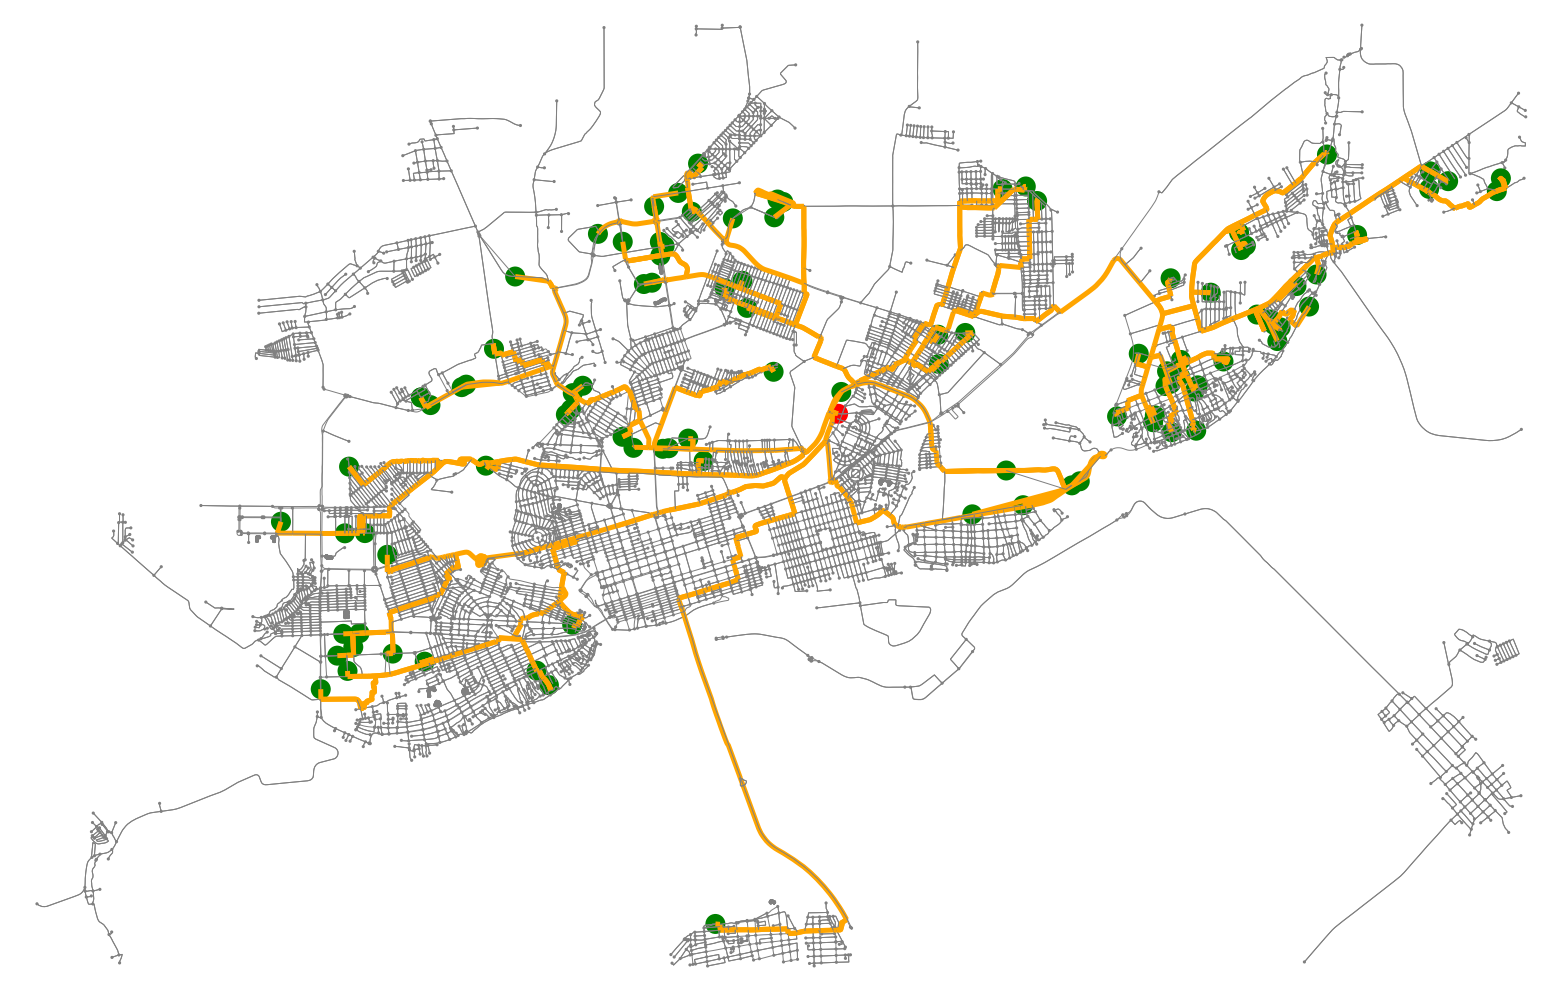

(3, 1072.572784006987)

In [25]:
get_shortest_paths_sum(G, graph_df, graph_edges, c_obj, c_nodes)

In [ ]:
get_lightest_tree(G, graph_df, graph_edges, c_obj, c_nodes)